In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime
from matplotlib import pyplot as plt

In [2]:
from function import *

load raw data of ohlcv

In [9]:
clean_df = pd.read_csv('clean_data/btc_1h.csv')
clean_df.head()

,timestamp,open,high,low,close,volume,datetime
0,1668988800000,16279.50,16295.00,16123.01,16268.73,14167.43968,2022-11-21 00:00:00
1,1668992400000,16268.12,16283.06,16191.00,16214.15,7872.39775,2022-11-21 01:00:00
2,1668996000000,16214.15,16219.99,15905.88,16010.70,23043.32117,2022-11-21 02:00:00
3,1668999600000,16010.31,16110.55,15897.15,16073.75,17133.07210,2022-11-21 03:00:00
4,1669003200000,16073.15,16319.00,16064.22,16149.97,18837.79424,2022-11-21 04:00:00


find 24hr close price change<br>
it will be numerical target

In [8]:
raw_target_df = max_rolling_change(clean_df, 'close', 'timestamp', 24)
raw_target_df.head()

,timestamp,open,high,low,close,volume,datetime,max_close_change
0,1668988800000,16279.50,16295.00,16123.01,16268.73,14167.43968,2022-11-21 00:00:00,-3.806136
1,1668992400000,16268.12,16283.06,16191.00,16214.15,7872.39775,2022-11-21 01:00:00,-3.482329
2,1668996000000,16214.15,16219.99,15905.88,16010.70,23043.32117,2022-11-21 02:00:00,-2.255866
3,1668999600000,16010.31,16110.55,15897.15,16073.75,17133.07210,2022-11-21 03:00:00,-2.639272
4,1669003200000,16073.15,16319.00,16064.22,16149.97,18837.79424,2022-11-21 04:00:00,-3.098767


see the distribution of target to put it into bins

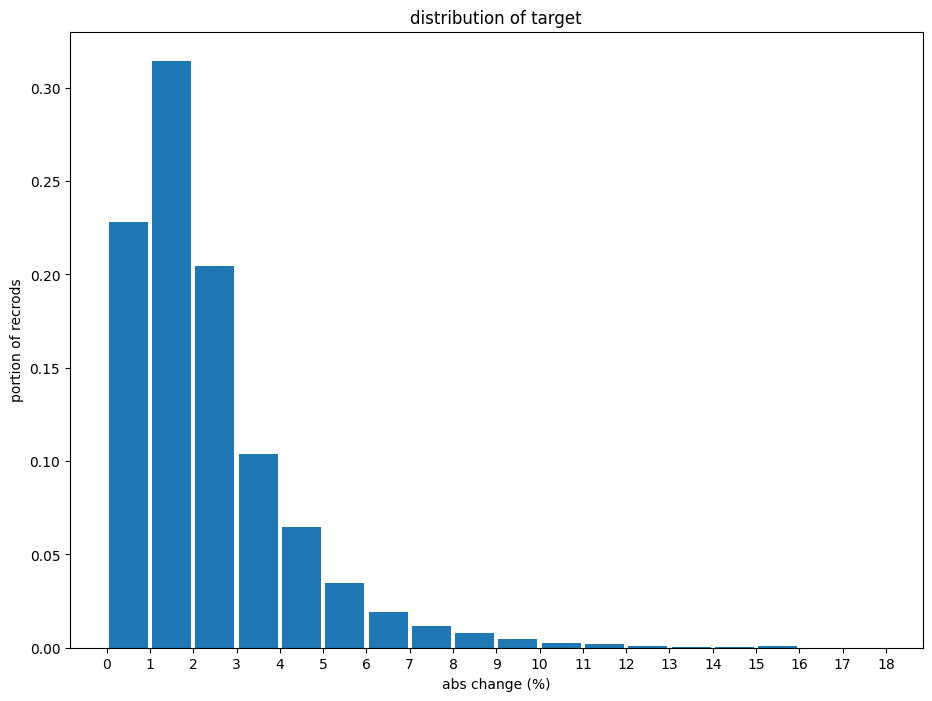

In [16]:
plt.figure(figsize=(11, 8))
plt.hist(abs(raw_target_df['max_close_change']), bins=np.arange(0, 19, 1), rwidth=0.9, density=True)
plt.xticks(np.arange(0, 19, 1))
plt.title('distribution of target')
plt.xlabel('abs change (%)')
plt.ylabel('portion of recrods')
plt.show()

put target into meaningfull bins<br>
it will be categorical target

In [22]:
bin_target_df = raw_target_df.dropna()
borders = [-2, -1, 1, 2]
bin_target_df['target_bin'] = bin_target_df['max_close_change'].apply(lambda x: target_to_bins(x, borders))

C:\Users\ablay\AppData\Local\Temp\ipykernel_6568\3594714583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_target_df['target_bin'] = bin_target_df['max_close_change'].apply(lambda x: target_to_bins(x, borders))


look for most potential time of day to start a trade<br>
period with less steady changes (bin#2)

In [23]:
bin_target_df['hr'] = pd.to_datetime(bin_target_df['datetime']).dt.hour

C:\Users\ablay\AppData\Local\Temp\ipykernel_6568\345432654.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_target_df['hr'] = pd.to_datetime(bin_target_df['datetime']).dt.hour


In [28]:
(bin_target_df
 [bin_target_df['target_bin']==2]
 .groupby('hr')
 .agg(cnt=('close', 'count'))
 .reset_index()
 .sort_values(by='cnt')
)

,hr,cnt
6,6,157
13,13,159
4,4,161
7,7,161
3,3,162
5,5,162
11,11,163
10,10,164
12,12,164
2,2,165


we now know that the most potential time to start trade ends at 06:00 UTC+0<br>
just remember it, and lets save the entire dataset we got

In [27]:
bin_target_df.to_csv('clean_data/target_df.csv', index=False)